<h1>Dados Covid-19 - Buscando Padrões</h1>

Dados obtidos do site <a href="https://brasil.io">Brasil.io</a>. O qual disponibiliza não apenas os dados como também documentação, diversas visualizações dos dados, uma API de acesso além do código fonte de tudo.

URL direta dos dados: <a href="https://brasil.io/dataset/covid19/files/">https://brasil.io/dataset/covid19/files/</a>.

Data de download: 02/03/2021.

Carga da biblioteca gráfica:

In [1]:
library("ggplot2")

Carga dos dados.

In [2]:
dados <- read.csv("../input/covid19/caso.csv", header = TRUE, stringsAsFactors = FALSE)

Dados de Regiões de Saúde do Rio de Janeiro:
<img src="regioes_saude_habitantes_rj.png" />

In [3]:
regioes_saude <- read.csv("../input/covid19/regioes_saude.csv", header = TRUE, stringsAsFactors = FALSE)

Vamos manter apenas os dados necessários:

In [4]:
dados <- dados[dados$state == "RJ" & dados$place_type == "city", ]
dados <- dados[ , - c(2, 4, 9)] # state, place_type, estimated_population_2019
dados <- dados[dados$city != "Importados/Indefinidos", ]

Número de mortes por dia:

In [5]:
dados$deaths_day <- 0

municipios <- sort(unique(dados$city))

for (municipio in municipios) {
  indices <- sort(dados[dados$city == municipio, "order_for_place"])
  acumulado <- 0
  for (indice in indices) {
    mortes_no_dia <- dados[dados$city == municipio & dados$order_for_place == indice, "deaths"] - acumulado
    dados[dados$city == municipio & dados$order_for_place == indice, "deaths_day"] <- mortes_no_dia
    acumulado <- dados[dados$city == municipio & dados$order_for_place == indice, "deaths"]
  }
}

<h2>Buscando padrões - Média 100k Habitantes</h2>

Média de mortes por semana:

In [6]:
# seleciona apenas colunas de interesse
temp <- dados[ , c("date", "city", "estimated_population", "deaths_day")]

# todas as datas que existem no conjunto de dados
datas <- sort(unique(temp$date))

linha <- nrow(temp)
for (municipio in municipios) {
  populacao <- unique(temp[temp$city == municipio, "estimated_population"])
  for (data in datas) {
    if (nrow(temp[temp$city == municipio & temp$date == data,]) == 0) {
      linha <- linha + 1
      temp[(linha), "date"] <- data
      temp[(linha), "city"] <- municipio
      temp[(linha), "estimated_population"] <- populacao
      temp[(linha), "deaths_day"] <- 0 
    }
  }
}

temp$week <- 0

datas <- sort(unique(temp$date))

# Para cada data o numero de sua semana
for (municipio in municipios) {
  i <- 0
  for (data in datas) {
    temp[temp$city == municipio & temp$date == data, "week"] <- as.integer(i / 7) + 1
    i <- i + 1
  }
}

# Semanas, cidades e média de mortes de cada semana:
semanal <- data.frame(week = 0, city = "", mean_deaths_week = 0, estimated_population=0, stringsAsFactors = FALSE)

semanas <- sort(unique(temp$week))

i <- 1
for (municipio in municipios) {
  for (semana in semanas) {
    total <- sum(temp[temp$city == municipio & temp$week == semana, "deaths_day"])
    linhas <- nrow(temp[temp$city == municipio & temp$week == semana, ])
    semanal[i, "week"] <- semana
    semanal[i, "city"] <- municipio
    semanal[i, "mean_deaths_week"] <- total / linhas
    i <- i + 1
  }
  semanal[semanal$city == municipio, "estimated_population"] <- unique(temp[temp$city == municipio, "estimated_population"])
}

Anexando os dados de Regiões de Saúde do Rio de Janeiro:

In [7]:
semanal <- merge(semanal, regioes_saude, by="city", all.x=TRUE)

Agregando os dados por Regiões de Saúde:

In [8]:
agregado <- aggregate(semanal[ , c("mean_deaths_week", "estimated_population")], by = list(semanal$week, semanal$health_region), FUN = sum)
colnames(agregado) <- c("week", "health_region", "mean_deaths_week", "estimated_population")

Adicionando atributo média de mortes por semana, por 100 mil habitantes:

In [9]:
agregado$mean_deaths_week_100k_inhabitants <- 100000 * agregado$mean_deaths_week / agregado$estimated_population

Utilizando dados agregados no tempo (semanas) e no espaço (regiões de saúde) vamos buscar padrões comparando os gráficos:

<h4>Comparando a região de saúde "Metropolitana I" com as outras:</h4>

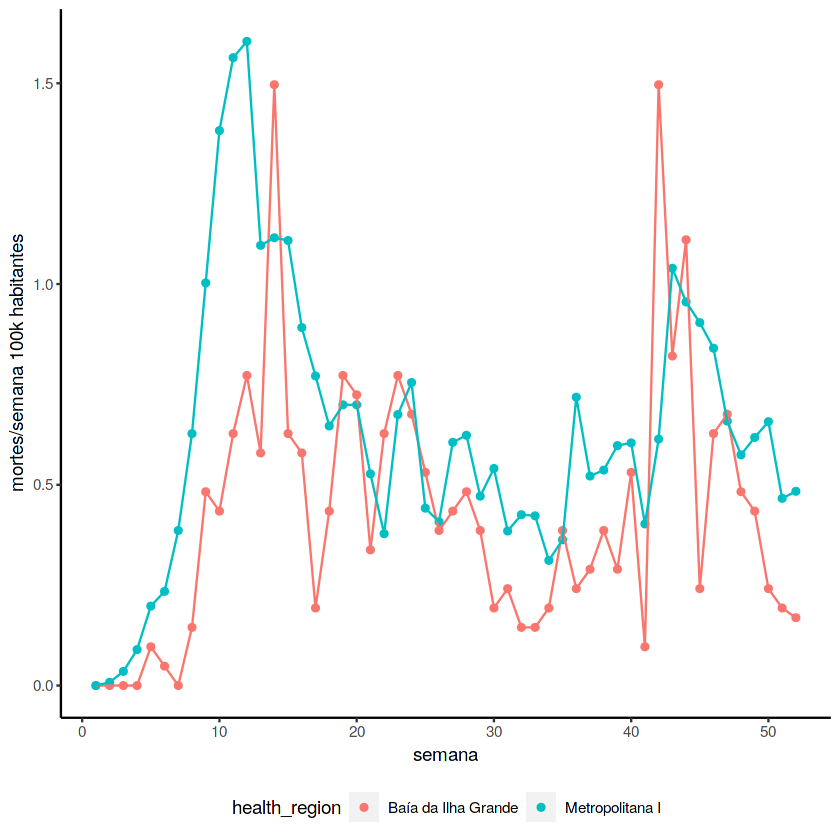

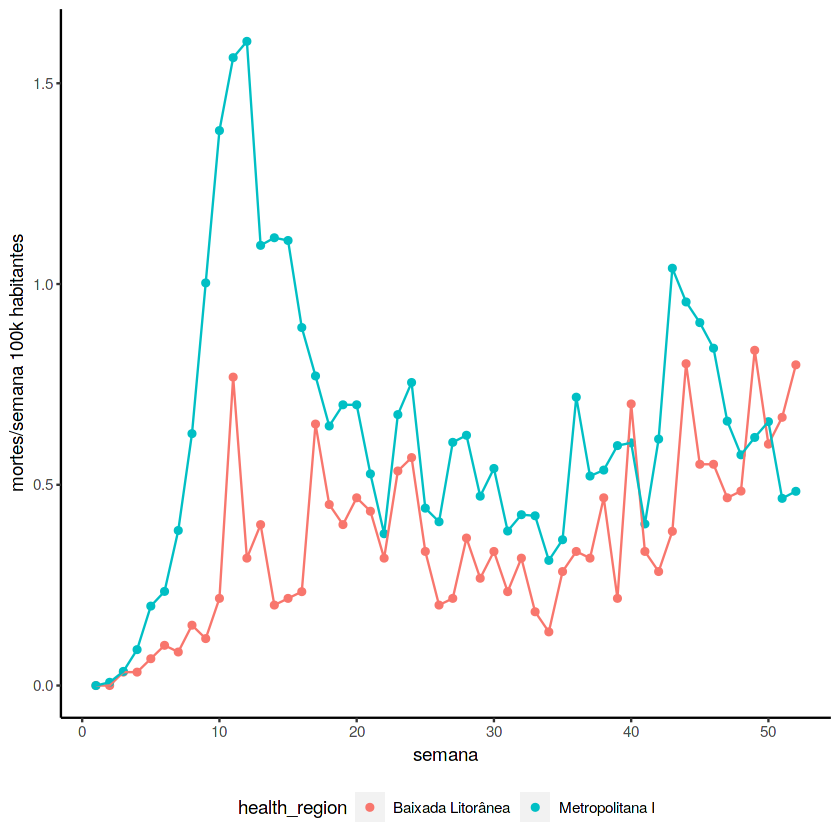

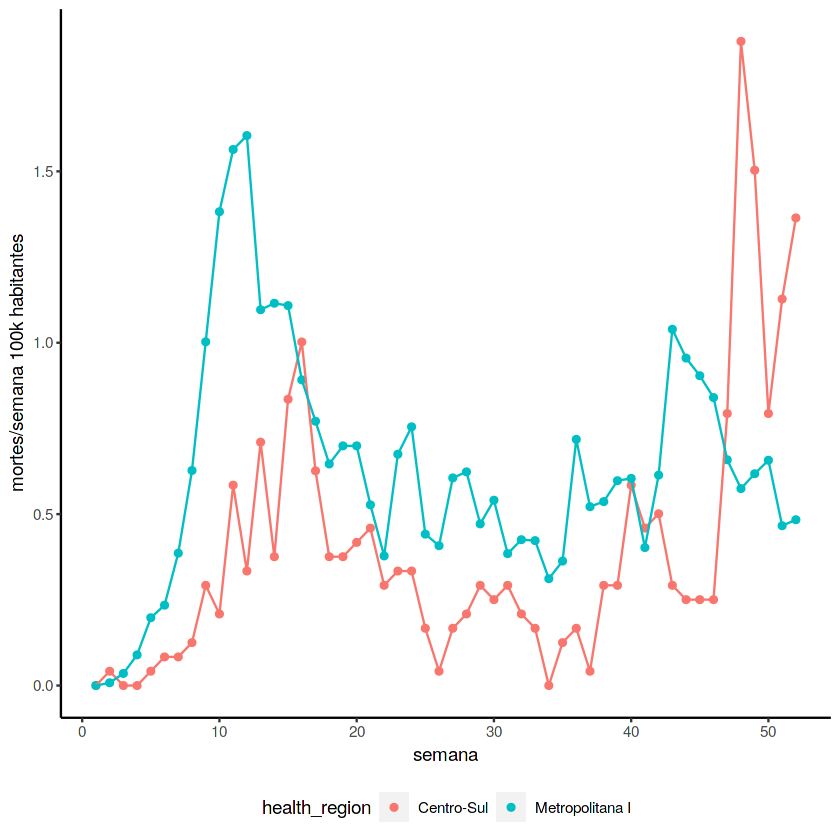

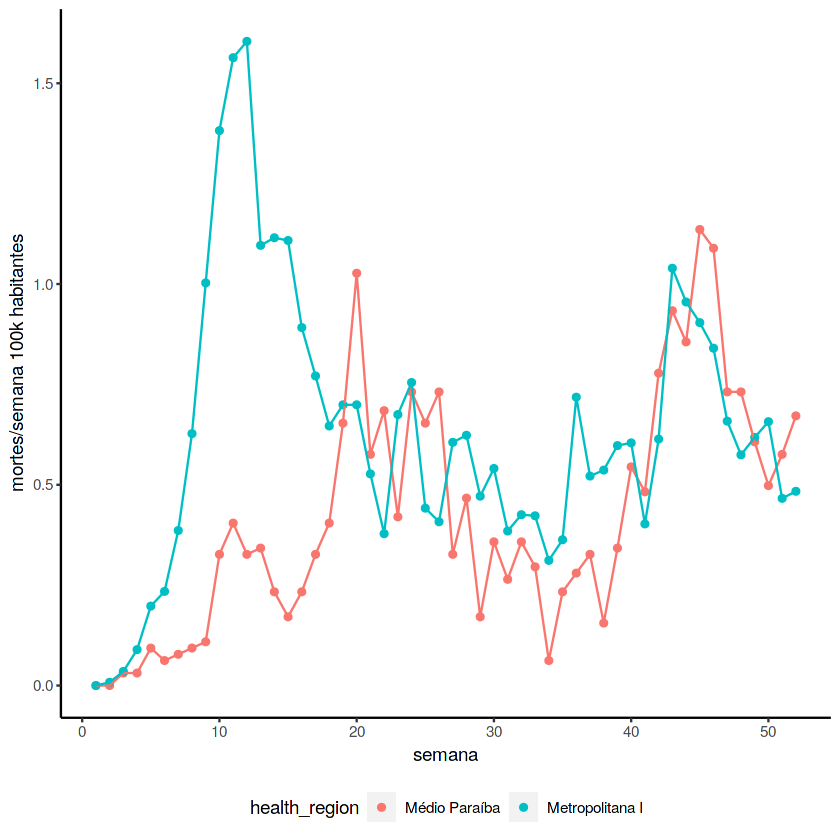

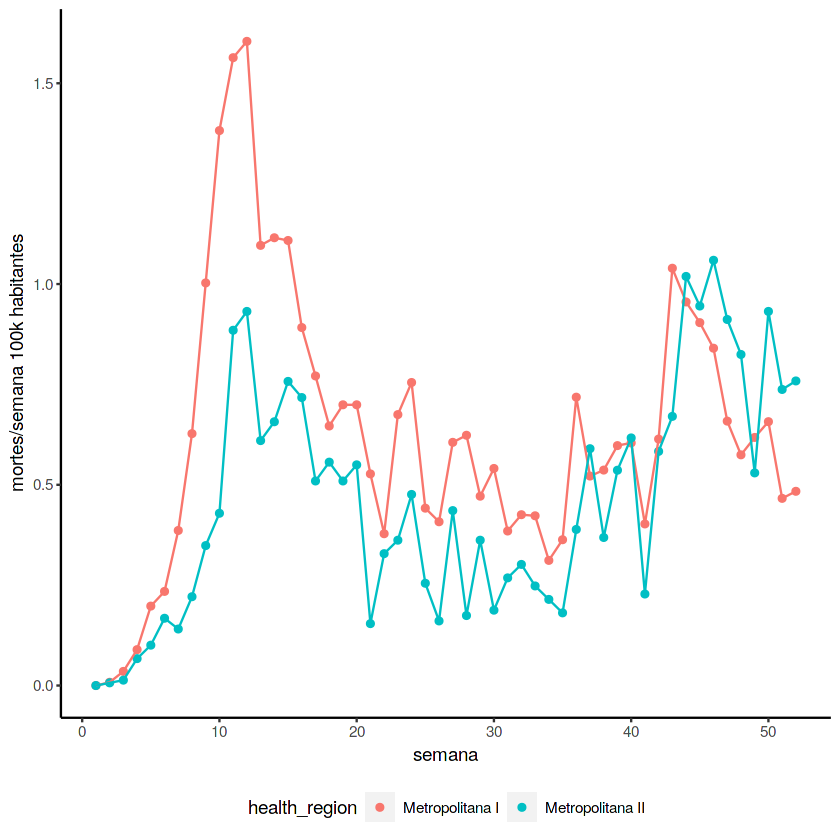

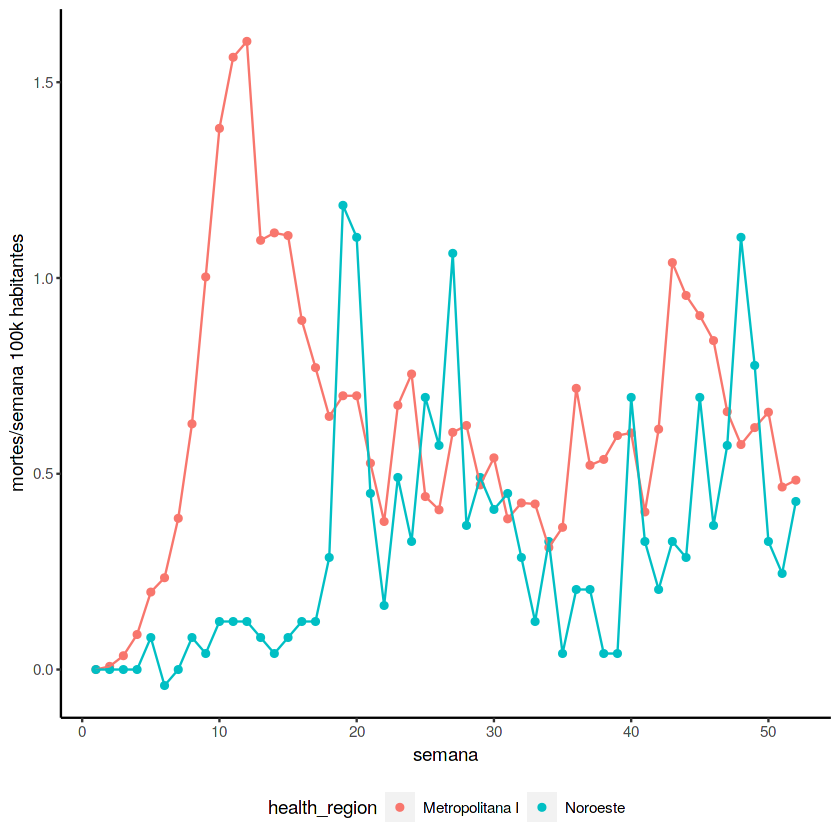

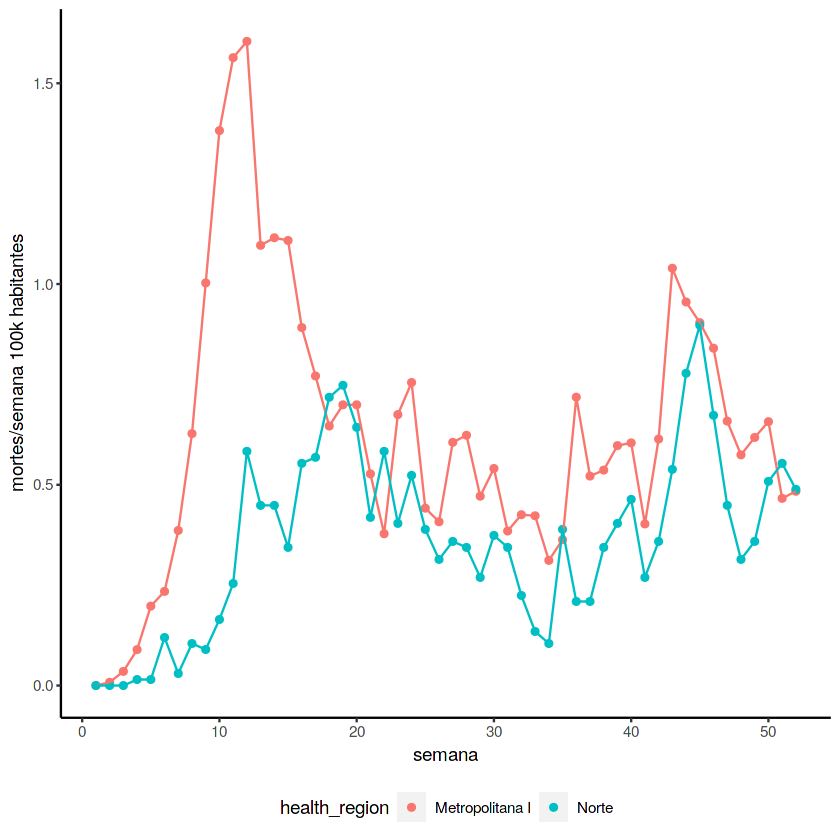

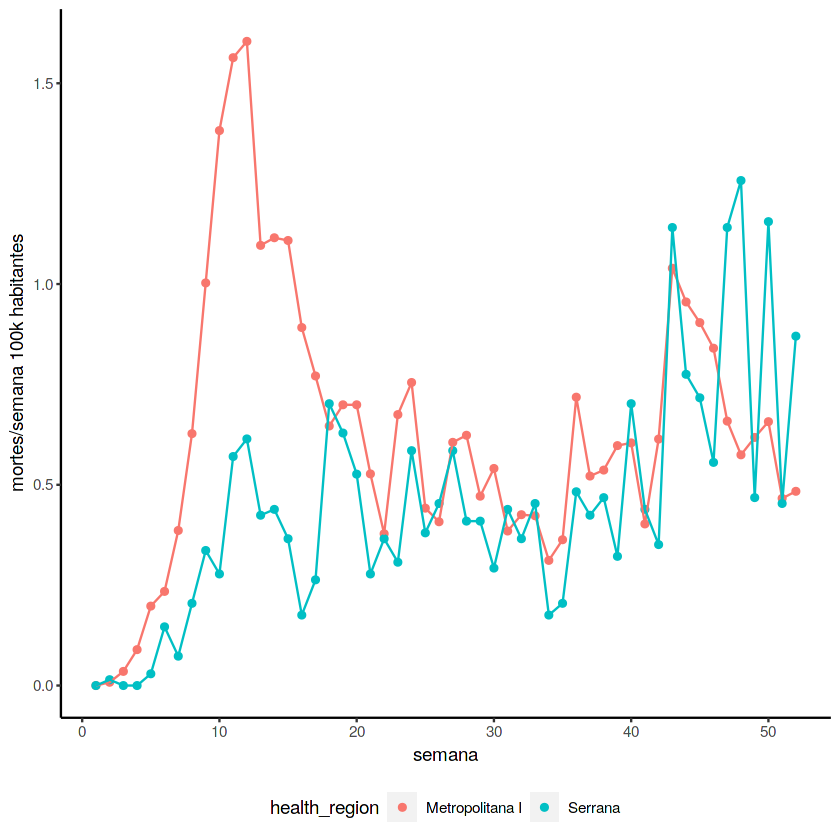

In [10]:
ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Baía da Ilha Grande"),], aes(x=week, y=mean_deaths_week_100k_inhabitants, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"))

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Baixada Litorânea" ),], aes(x=week, y=mean_deaths_week_100k_inhabitants, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Centro-Sul"),], aes(x=week, y=mean_deaths_week_100k_inhabitants, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"))

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Médio Paraíba" ),], aes(x=week, y=mean_deaths_week_100k_inhabitants, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Metropolitana II" ),], aes(x=week, y=mean_deaths_week_100k_inhabitants, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Noroeste"),], aes(x=week, y=mean_deaths_week_100k_inhabitants, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Norte"),], aes(x=week, y=mean_deaths_week_100k_inhabitants, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Serrana"),], aes(x=week, y=mean_deaths_week_100k_inhabitants, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"))

<h3>Buscando padrões - Variação Percentual da Média (duas semanas)</h3>

Calculando a variação percentual:

In [11]:
agregado$percentage_change <- 0

regioes <- sort(unique(agregado$health_region))
semanas <- sort(unique(agregado$week))

for (regiao in regioes) {
  ultimas_semanas <- c(0, 0, 0)
  
  for (semana in semanas) {
    esta_semana <- agregado[agregado$health_region == regiao & agregado$week == semana, "mean_deaths_week"]
    ultimas_semanas[semana %% 3 + 1] <- esta_semana
    
    mudanca_percentual <- 0
    if (esta_semana != 0) {
      if (semana > 3) {
        mudanca_percentual <- esta_semana / ultimas_semanas[(semana + 1) %% 3 + 1] - 1
      } else {
        mudanca_percentual <- esta_semana / ultimas_semanas[2] - 1
      }
      
      if (is.infinite(mudanca_percentual)) {  # divisao por zero (Inf)?
        mudanca_percentual <- 0
      }
    }
    agregado[agregado$health_region == regiao & agregado$week == semana, "percentage_change"] <- mudanca_percentual
    
  }
}

Comparação entre as regiões tomando como base a região Metropolitana I:

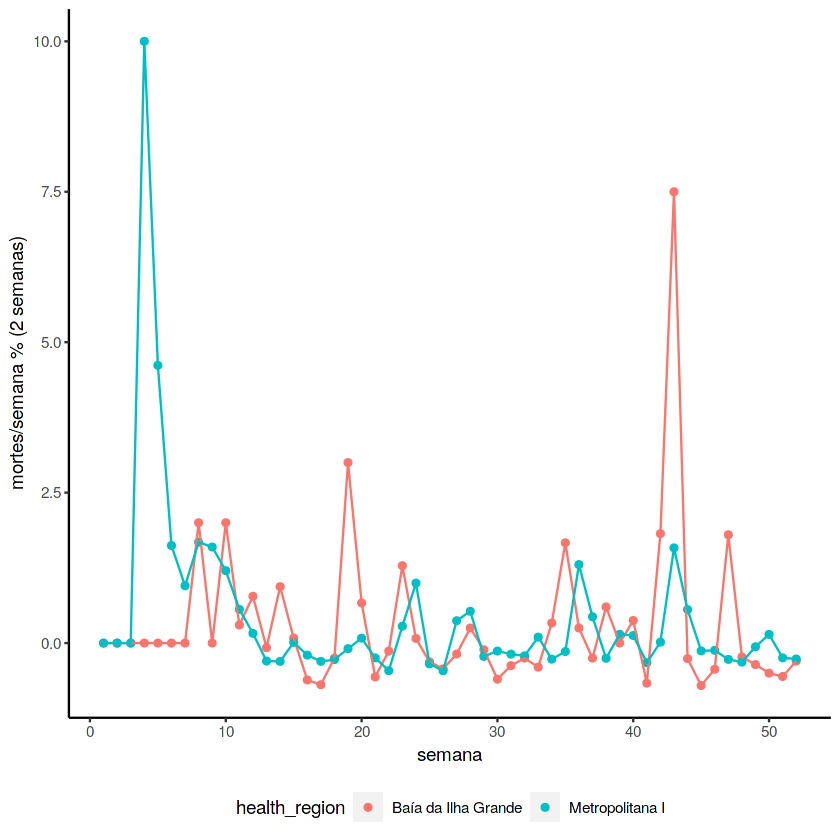

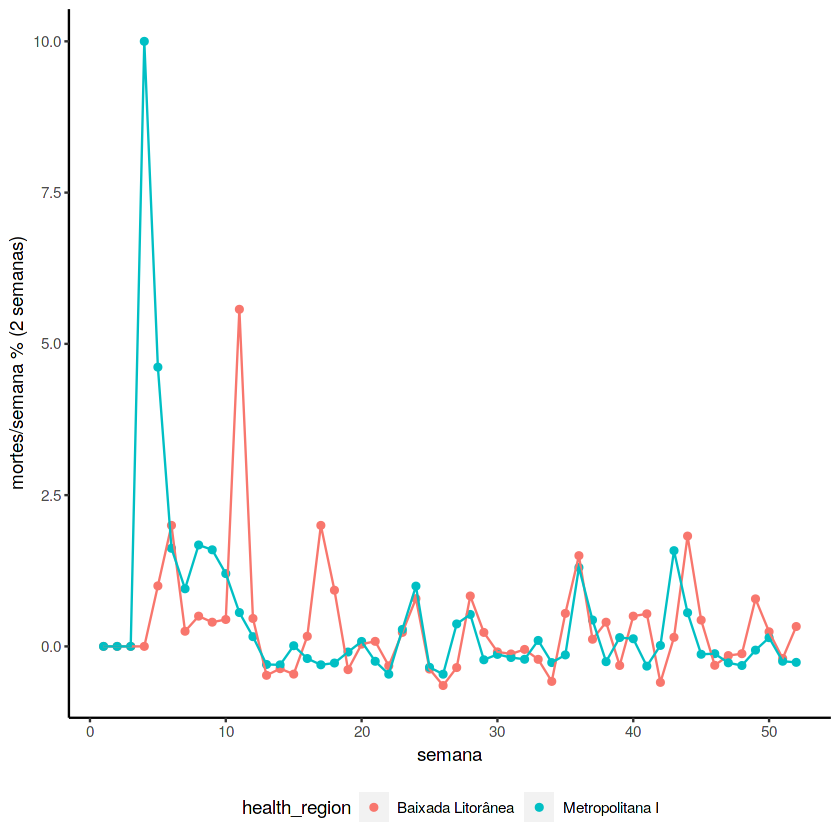

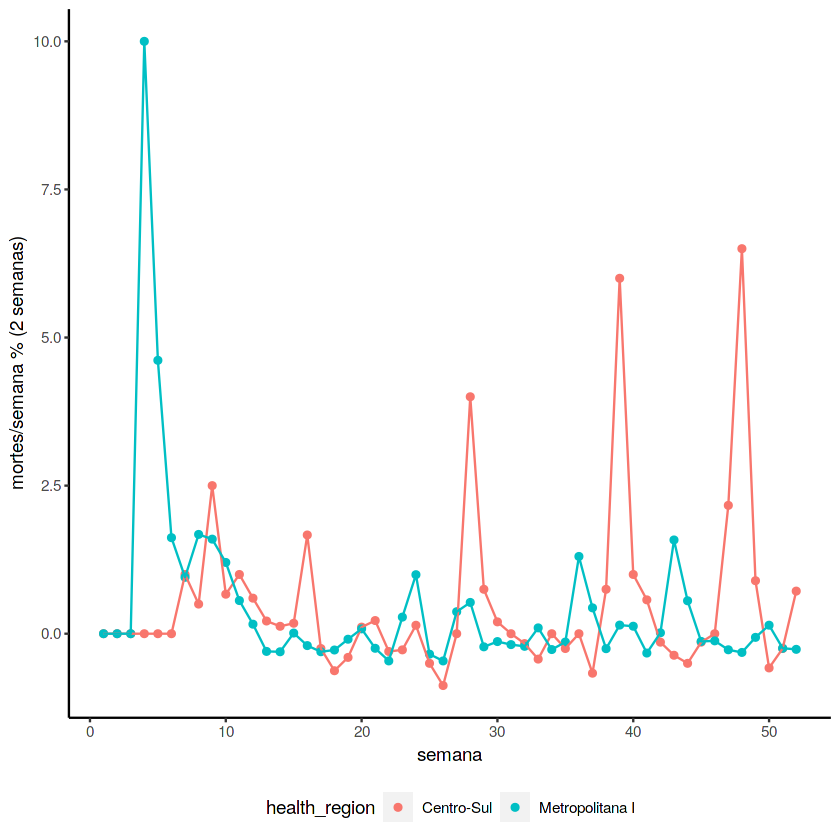

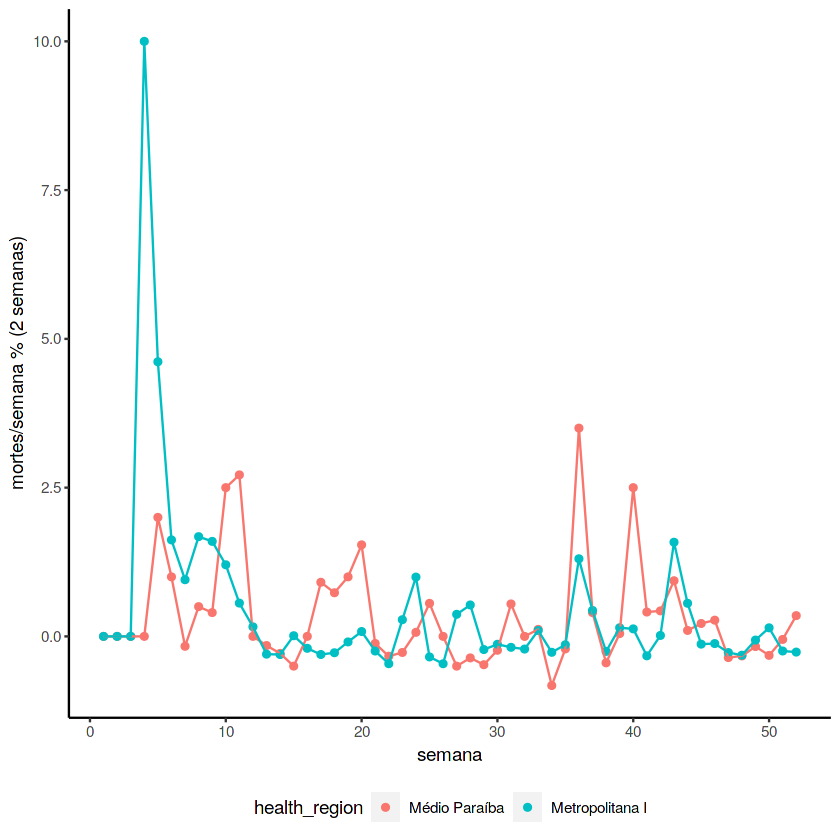

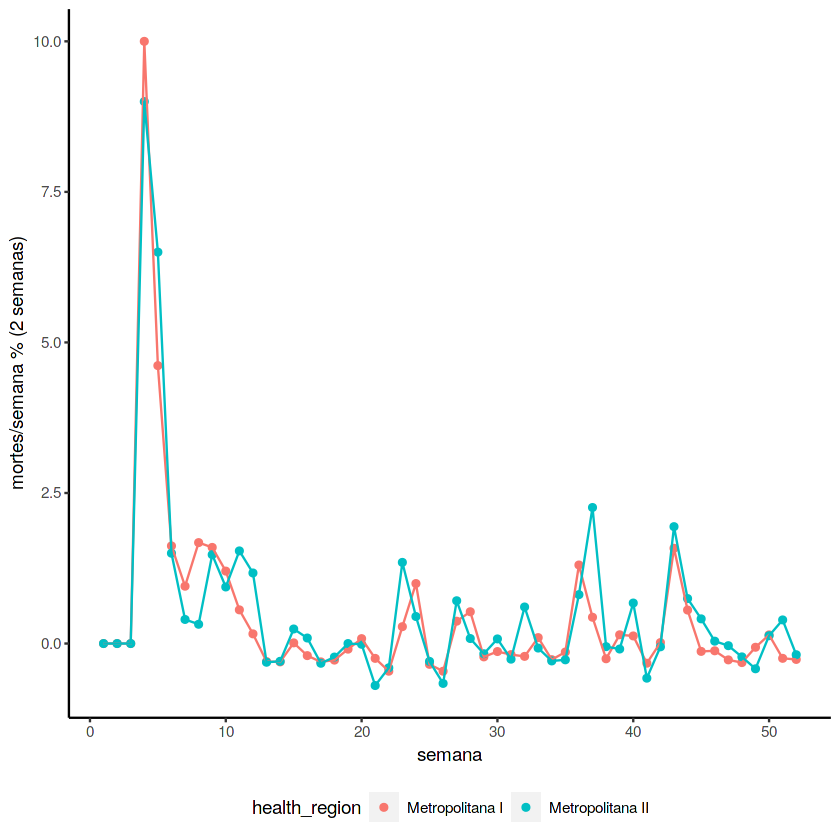

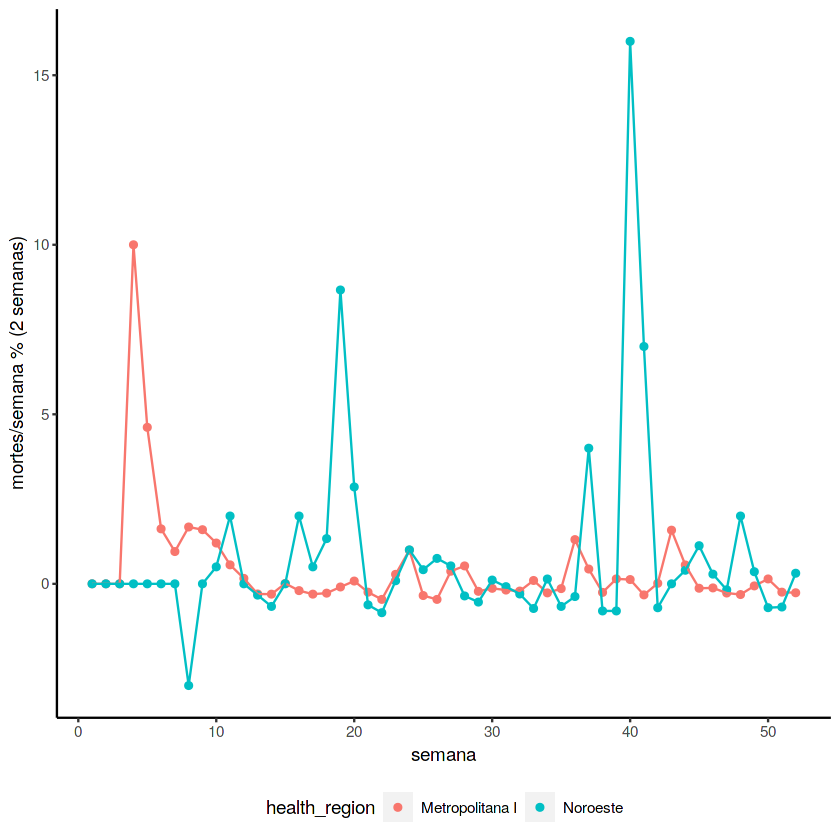

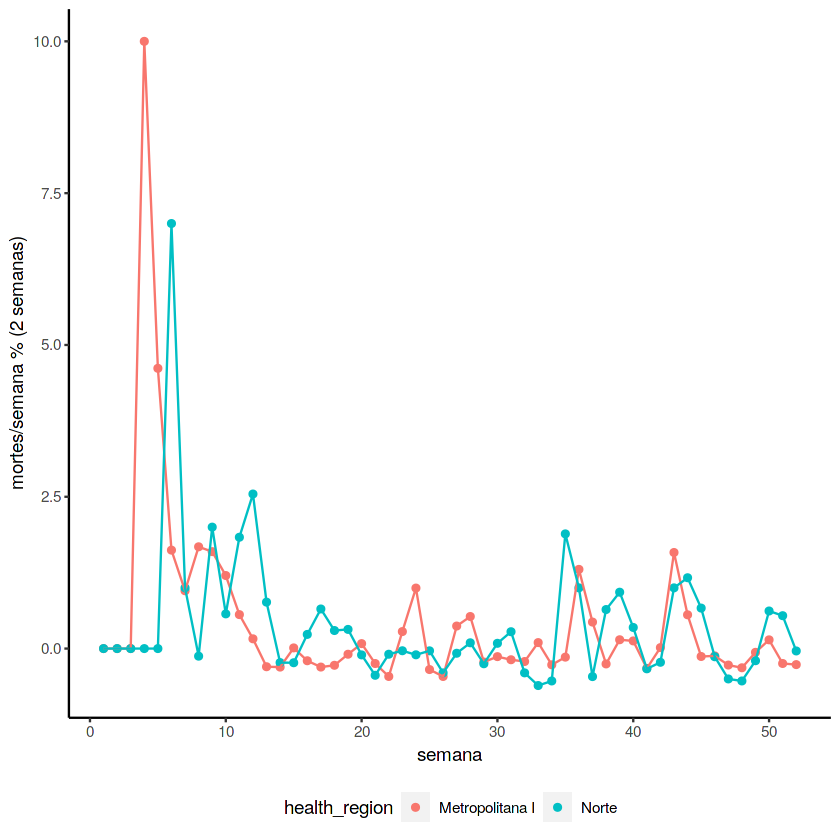

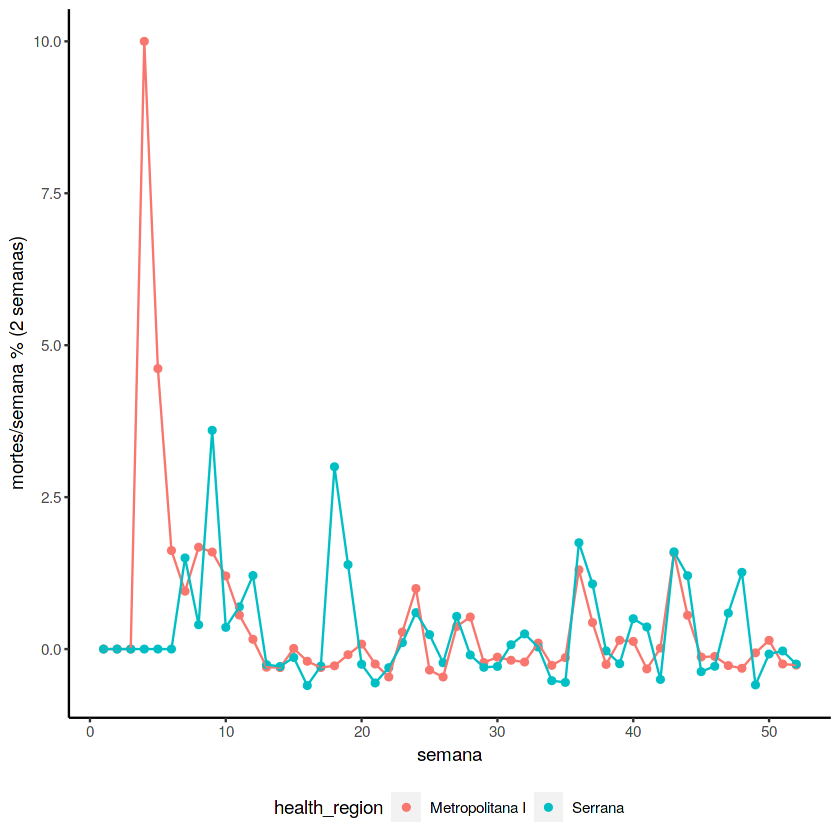

In [12]:
ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Baía da Ilha Grande"),], aes(x=week, y=percentage_change, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana % (2 semanas)") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"))

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Baixada Litorânea" ),], aes(x=week, y=percentage_change, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana % (2 semanas)") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Centro-Sul"),], aes(x=week, y=percentage_change, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana % (2 semanas)") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"))

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Médio Paraíba" ),], aes(x=week, y=percentage_change, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana % (2 semanas)") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Metropolitana II" ),], aes(x=week, y=percentage_change, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana % (2 semanas)") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Noroeste"),], aes(x=week, y=percentage_change, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana % (2 semanas)") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Norte"),], aes(x=week, y=percentage_change, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana % (2 semanas)") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

ggplot(agregado[agregado$health_region %in% c("Metropolitana I", "Serrana"),], aes(x=week, y=percentage_change, group=health_region)) +
  geom_point(aes(color=health_region)) +
  geom_line(aes(color=health_region), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana % (2 semanas)") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black")) 

A variação percentual parece mais adequada para a busca de padrões.